#***Urdu Sentiment Analysis Using MultiLingual BERT***
By Nakshatra Singh

This notebook is an illustration on how to build a Multilingual BERT model for Urdu Sentiment Analysis using Transformers Library provided by Huggingface.

###**Using Google GPU for Training**

Google colab offers free GPUs and TPUs! Since we'll be training a large model it's best to take advantage of this (in this case we'll use GPU), otherwise training can take long time.

A GPU can be added by going to the menu and selecting:

`Edit -> Notebook Settings -> Hardware Accelerator -> (GPU)`

Then run the following cell to confirm that a GPU is detected.

In [1]:
import tensorflow as tf
# Get the device GPU name 
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at : {}'.format(device_name)) 
else:
  raise SystemError('GPU not found!')   

Found GPU at : /device:GPU:0


###**Setting up Imports and Downloading the Dependencies**

Firstly we'll need the [Transformers library](https://huggingface.co/transformers/) by Hugging Face.

In [1]:
!pip install -qq transformers

     |████████████████████████████████| 1.3MB 11.3MB/s 
     |████████████████████████████████| 890kB 52.8MB/s 
     |████████████████████████████████| 1.1MB 52.9MB/s 
     |████████████████████████████████| 2.9MB 50.6MB/s 


I have downloaded all the Libraries and Dependencies required for this Project in one particular cell.

In [2]:
#@ All the necessary and required Imports for this Notebook.
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

###**Retrieve Dataset**

Let's download [the dataset](https://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set) which is uploaded on my google drive.  

In [3]:
!gdown --id 1gYAXJMnOEusSTy3T6qD3KVshI-J0F57_ 

Downloading...
From: https://drive.google.com/uc?id=1gYAXJMnOEusSTy3T6qD3KVshI-J0F57_
To: /content/Roman Urdu DataSet.csv
100% 1.63M/1.63M [00:00<00:00, 52.0MB/s]


We'll use `pandas` to parse the csv file and see what the dataframe looks like.

In [4]:
df = pd.read_csv('/content/Roman Urdu DataSet.csv')
df.head() 

,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive,Unnamed: 2
0,sahi bt h,Positive,NaN
1,"Kya bt hai,",Positive,NaN
2,Wah je wah,Positive,NaN
3,Are wha kaya bat hai,Positive,NaN
4,Wah kya baat likhi,Positive,NaN


###**Preparing the data**

Let's clean the dataframe, rename the columns and drop unnecessary columns.  

In [5]:
#@ Dropping Unnamed column.
df = df.drop(['Unnamed: 2'], axis=1) 
#@ Renaming the 2 columns to understandable formats.
df = df.rename(columns={ df.columns[0]: "text" , df.columns[1]: "sentiment"}) 

We'll look at our cleaned dataframe and use this for training our model.

In [6]:
#@ First 5 lines of the dataframe.
df.head() 

,text,sentiment
0,sahi bt h,Positive
1,"Kya bt hai,",Positive
2,Wah je wah,Positive
3,Are wha kaya bat hai,Positive
4,Wah kya baat likhi,Positive


In [7]:
#@ columns datatypes.
df.dtypes

 '''Both are columns are object datatypes. We'll need to convert
 sentiment column to a int for our BERT model to take it as input'''

text         object
sentiment    object
dtype: object

In [8]:
#@ Number of data points.
df.shape

(20228, 2)

In [9]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20228 entries, 0 to 20227
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       20227 non-null  object
 1   sentiment  20228 non-null  object
dtypes: object(2)
memory usage: 316.2+ KB


How many target variables are we dealing with?

In [10]:
df.sentiment.unique()

array(['Positive', 'Neutral', 'Negative', 'Neative'], dtype=object)

OH NO! I guess *Neative* here is a misspelled word and we'll replace it with *Negative*. 

In [11]:
df['sentiment'] = df['sentiment'].str.replace('Neative', 'Negative')  

Finally, we'll be converting the sentiments to numerical variables and then we'll convert the whole column to an *integer datatype* for our BERT Model.

In [12]:
#@ Converting to numerical variables.
df['sentiment'] = df['sentiment'].str.replace('Negative', '0')
df['sentiment'] = df['sentiment'].str.replace('Neutral', '1')
df['sentiment'] = df['sentiment'].str.replace('Positive', '2')

#@ Converting to integer datatype.
df['sentiment'] = df['sentiment'].astype(int)

Now, let's check the target variables.

In [13]:
df.sentiment.unique() 

array([2, 1, 0])

We'll plot a countplot using seaborn to have more visualization for the distribution of the target.

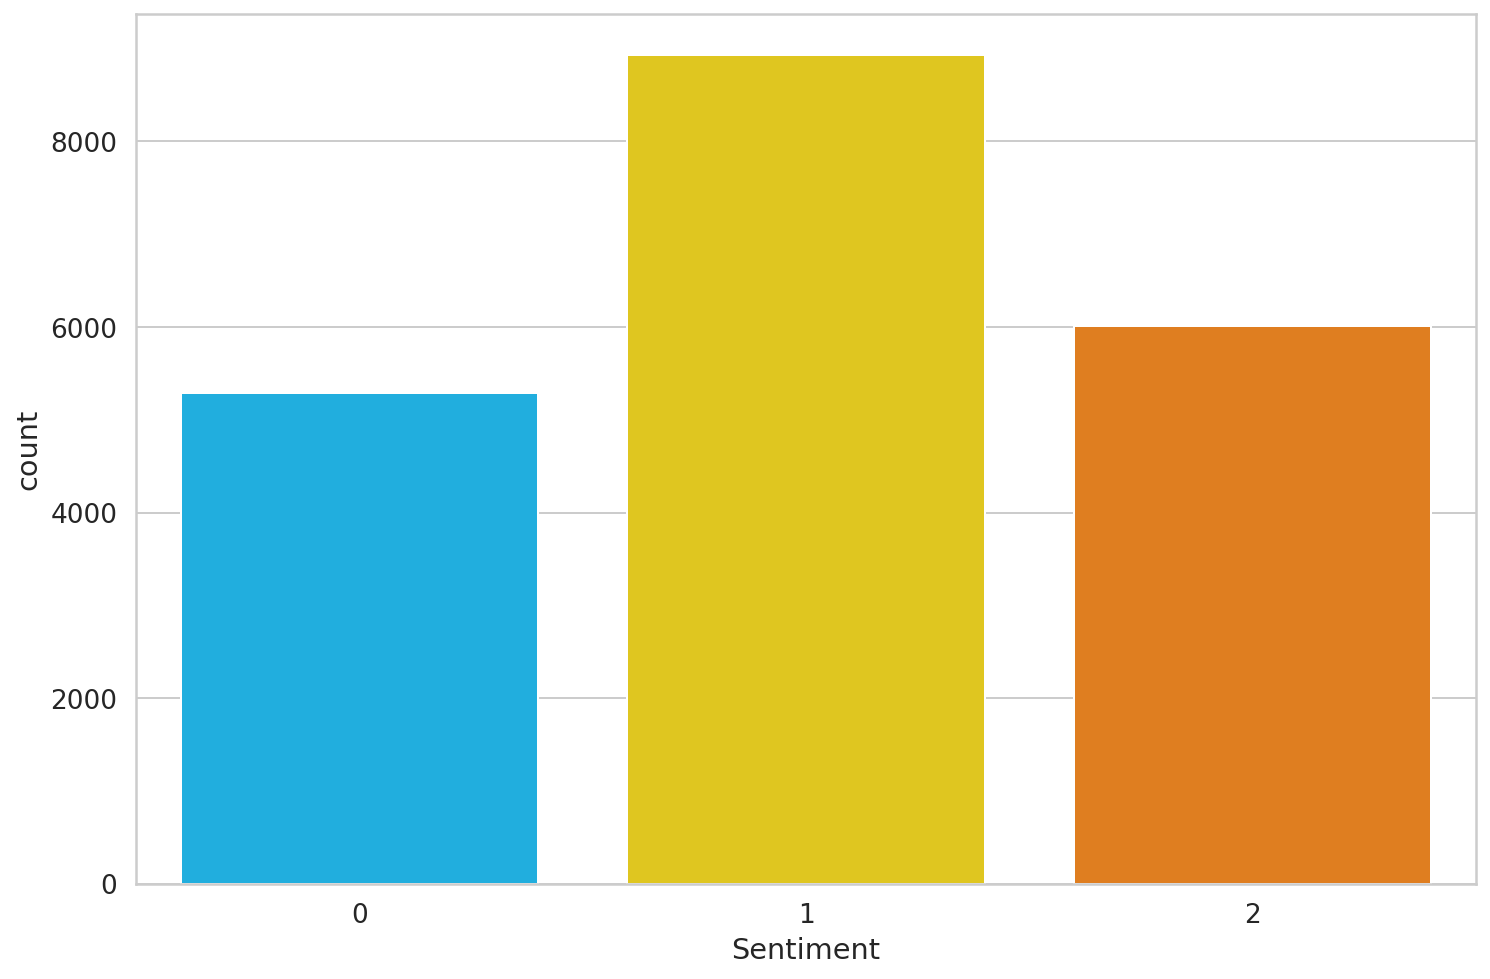

In [14]:
sns.countplot(x = df.sentiment)
plt.xlabel('Sentiment');

###**Data Preprocessing**

The Transformers library provides with a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!  Since, we have urdu language, we'll use [BERTs mutlilingual model](https://github.com/google-research/bert/blob/master/multilingual.md).

In [15]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer). 

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) 

We'll use this text to understand the tokenization process.

In [17]:
sample_txt = 'Wah kya baat likhi'

Some basic operations can convert the text to tokens and tokens to unique integers (ids).

In [18]:
tokens = tokenizer.tokenize(sample_txt) 
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}') 

 Sentence: Wah kya baat likhi
   Tokens: ['W', '##ah', 'ky', '##a', 'ba', '##at', 'lik', '##hi']
Token IDs: [160, 12257, 87147, 10113, 15688, 10526, 29694, 11924]


###**Special Tokens**

[SEP] - marker for ending of a sentence.

In [19]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

[CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification.

In [20]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token [PAD] for padding.

In [21]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token.

In [22]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [encode_plus()](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method.

In [23]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,             
    add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',         # Pad to max Length
    truncation=True,
    return_attention_mask=True,    
    return_tensors='pt'           # Return PyTorch tensors
)
encoding.keys() 

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32.

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0] 

32


tensor([  101,   160, 12257, 87147, 10113, 15688, 10526, 29694, 11924,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

The attention mask has the same length.

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]  

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

We can inverse the tokenization to have a look at the special tokens.

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]) 

['[CLS]',
 'W',
 '##ah',
 'ky',
 '##a',
 'ba',
 '##at',
 'lik',
 '##hi',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

We have all building blocks required to create a PyTorch dataset. Let's do it!!!!

In [33]:
class SentimentDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'urdu_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    } 

The tokenizer is doing most of the heavy lifting for us. We also return the urdu texts, so it'll be easier to evaluate the predictions from our model. Let's split the data. First we'll split the data to training and testing sets then we'll split testing set to validation and testing.

In [34]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)   
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED) 

Shapes of the dataframe we split.

In [35]:
df_train.shape, df_val.shape, df_test.shape 

((18205, 2), (1011, 2), (1012, 2))

We also need to create a couple of data loaders. Here's a helper function to do it.

In [36]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentimentDataset(
    texts=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
  ) 

We'll set up the model hyperparameters and create the final data loaders as inputs to our model.

In [37]:
BATCH_SIZE = 16
MAX_LEN = 160

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE) 

Our data loader should return 4 keys, The urdu text, input ids, attentions and targets.

In [38]:
data = next(iter(train_data_loader))
data.keys() 

dict_keys(['urdu_text', 'input_ids', 'attention_mask', 'targets'])

In [39]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape) 

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


###**Sentiment Classification using BERT and Hugging Face**

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on this task, we'll use BERTMultiLingual Model.

In [40]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) 

And try to use it on the encoding of our sample text.

In [41]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
) 

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on last_hidden_state: 

In [42]:
last_hidden_state.shape 

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config.

In [43]:
bert_model.config.hidden_size 

768

You can think of the `pooled_output` as a summary of the content. Let's look at the shape of the output.

In [44]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model.

In [45]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output) 

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU.

In [46]:
model = SentimentClassifier(3)    # Number of Classes
model = model.to(device)

In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length 

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs.

In [48]:
F.softmax(model(input_ids, attention_mask), dim=1) 

tensor([[0.2595, 0.3731, 0.3674],
        [0.2654, 0.3331, 0.4015],
        [0.3175, 0.3096, 0.3729],
        [0.2435, 0.4273, 0.3292],
        [0.3466, 0.3138, 0.3396],
        [0.3077, 0.3561, 0.3362],
        [0.3083, 0.3015, 0.3902],
        [0.2964, 0.3469, 0.3567],
        [0.2451, 0.3244, 0.4305],
        [0.3235, 0.3692, 0.3073],
        [0.2580, 0.3463, 0.3957],
        [0.3059, 0.3660, 0.3281],
        [0.3326, 0.3440, 0.3234],
        [0.2899, 0.2950, 0.4152],
        [0.3026, 0.2931, 0.4043],
        [0.2852, 0.3113, 0.4035]], device='cuda:0', grad_fn=<SoftmaxBackward>)

###**Training**

To reproduce the training procedure from the BERT paper, we'll use the [AdamW optimizer](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps.

In [49]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device) 


How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4, 5, 10

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for 10 epochs.

In [50]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad() 

  return correct_predictions.double() / n_examples, np.mean(losses) 

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_gradnorm](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader.

In [51]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses) 

Using those two, we can write our training loop. We'll also store the training history.

In [52]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print() 

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc 

Epoch 1/10
----------
Train loss 1.0722231505625277 accuracy 0.43477066739906617
Val   loss 1.1243147747591138 accuracy 0.45400593471810086

Epoch 2/10
----------
Train loss 1.0448812092859003 accuracy 0.45811590222466353
Val   loss 1.0207598572596908 accuracy 0.4708209693372898

Epoch 3/10
----------
Train loss 1.0159774858419421 accuracy 0.4827794561933535
Val   loss 1.0026708571240306 accuracy 0.5123639960435212

Epoch 4/10
----------
Train loss 0.9907595751993685 accuracy 0.5199670420214226
Val   loss 1.0039758794009686 accuracy 0.5370919881305638

Epoch 5/10
----------
Train loss 0.9553058959268728 accuracy 0.5445756660258171
Val   loss 0.9591710111126304 accuracy 0.5400593471810089

Epoch 6/10
----------
Train loss 0.92237977214773 accuracy 0.5699533095303488
Val   loss 0.9567596707493067 accuracy 0.5677546983184966

Epoch 7/10
----------
Train loss 0.8821564696218511 accuracy 0.6015380390002747
Val   loss 0.9307702910155058 accuracy 0.5855588526211671

Epoch 8/10
----------
Trai

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took a lot of time! This accuracy is quite shocking even tho the BERT model took around 3 hours to train. This could be due to many reasons:
- Poor optimized hyperparameters. (Epochs, batch size, padding length, optimizer, learning rate,etc)
- MultiLingual BERT isnt as optimized as the standard BERT model which is trained on english vocabulary.

You can increase the accuracy by training the model to more epochs and optimizing the hyperparameters.
 
 We can look at the training vs validation accuracy: 

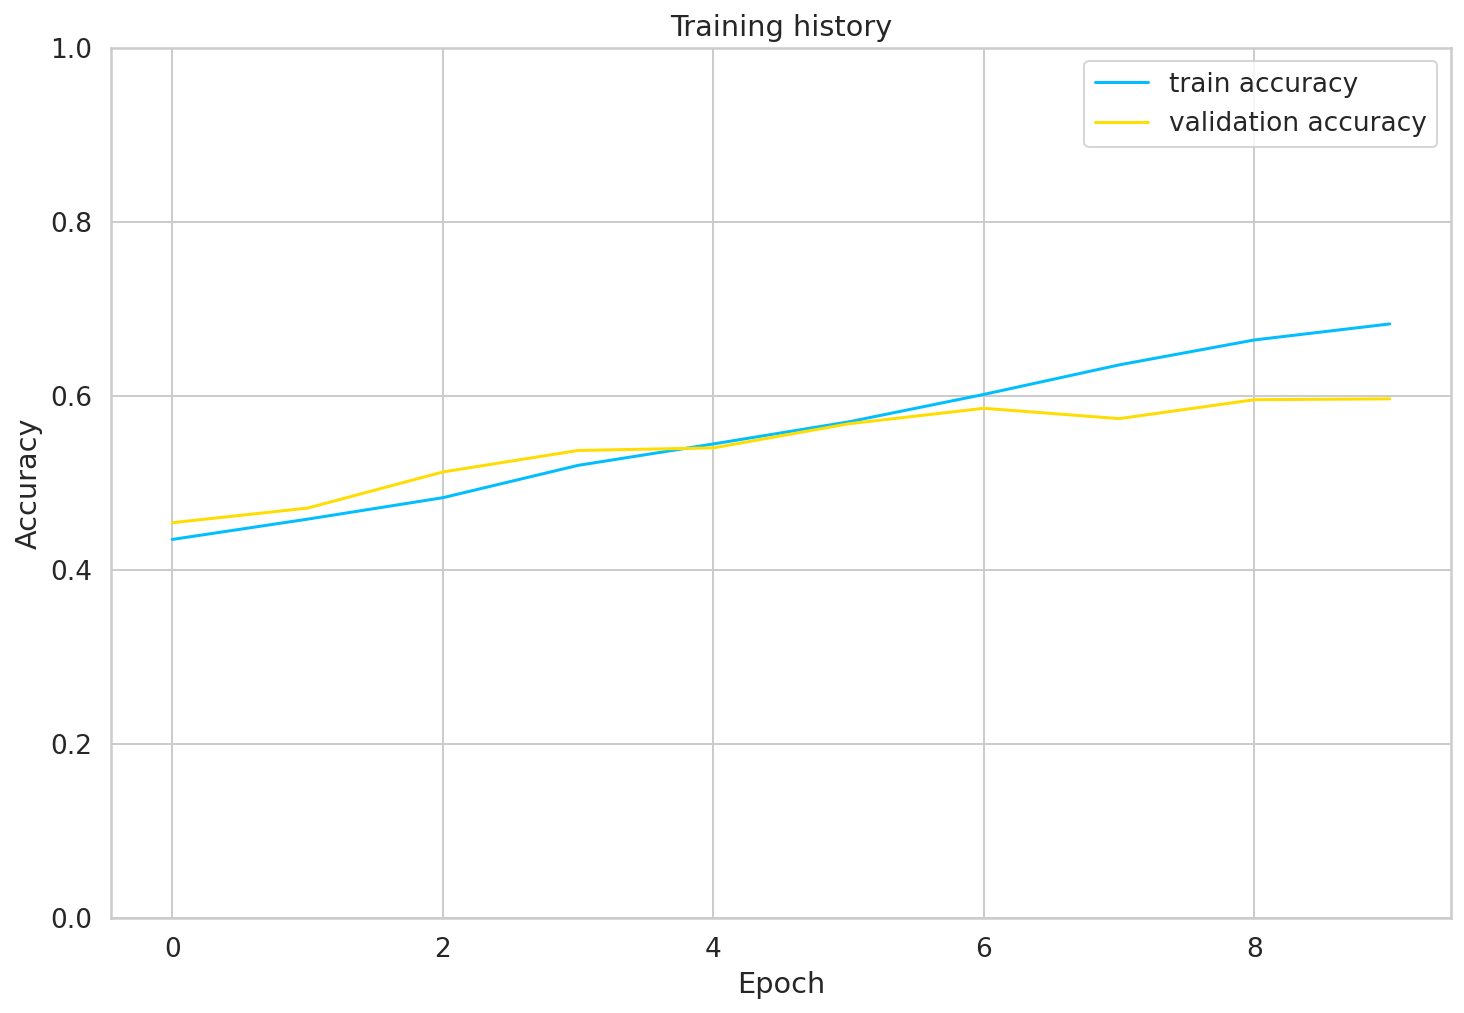

In [53]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]); 

The training accuracy starts to increase after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

###**Evaluation**

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data.

In [54]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item() 

0.5968379446640316

The accuracy is about the same as the training set. Our model seems to not overfit at the moment.

We'll define a helper function to get the predictions from our model.

In [57]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sentiment_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["urdu_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sentiment_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentiment_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the urud texts and the predicted probabilities (by applying the softmax on the model outputs).

In [58]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
) 

In [66]:
class_names = ['negative', 'neutral', 'positive'] 

Let's have a look at the classification report.

In [87]:
print(classification_report(y_test, y_pred, target_names=class_names)) 

              precision    recall  f1-score   support

    negative       0.40      0.42      0.41       248
     neutral       0.69      0.66      0.67       456
    positive       0.64      0.64      0.64       308

    accuracy                           0.60      1012
   macro avg       0.57      0.58      0.57      1012
weighted avg       0.60      0.60      0.60      1012



We'll continue with the confusion matrix.

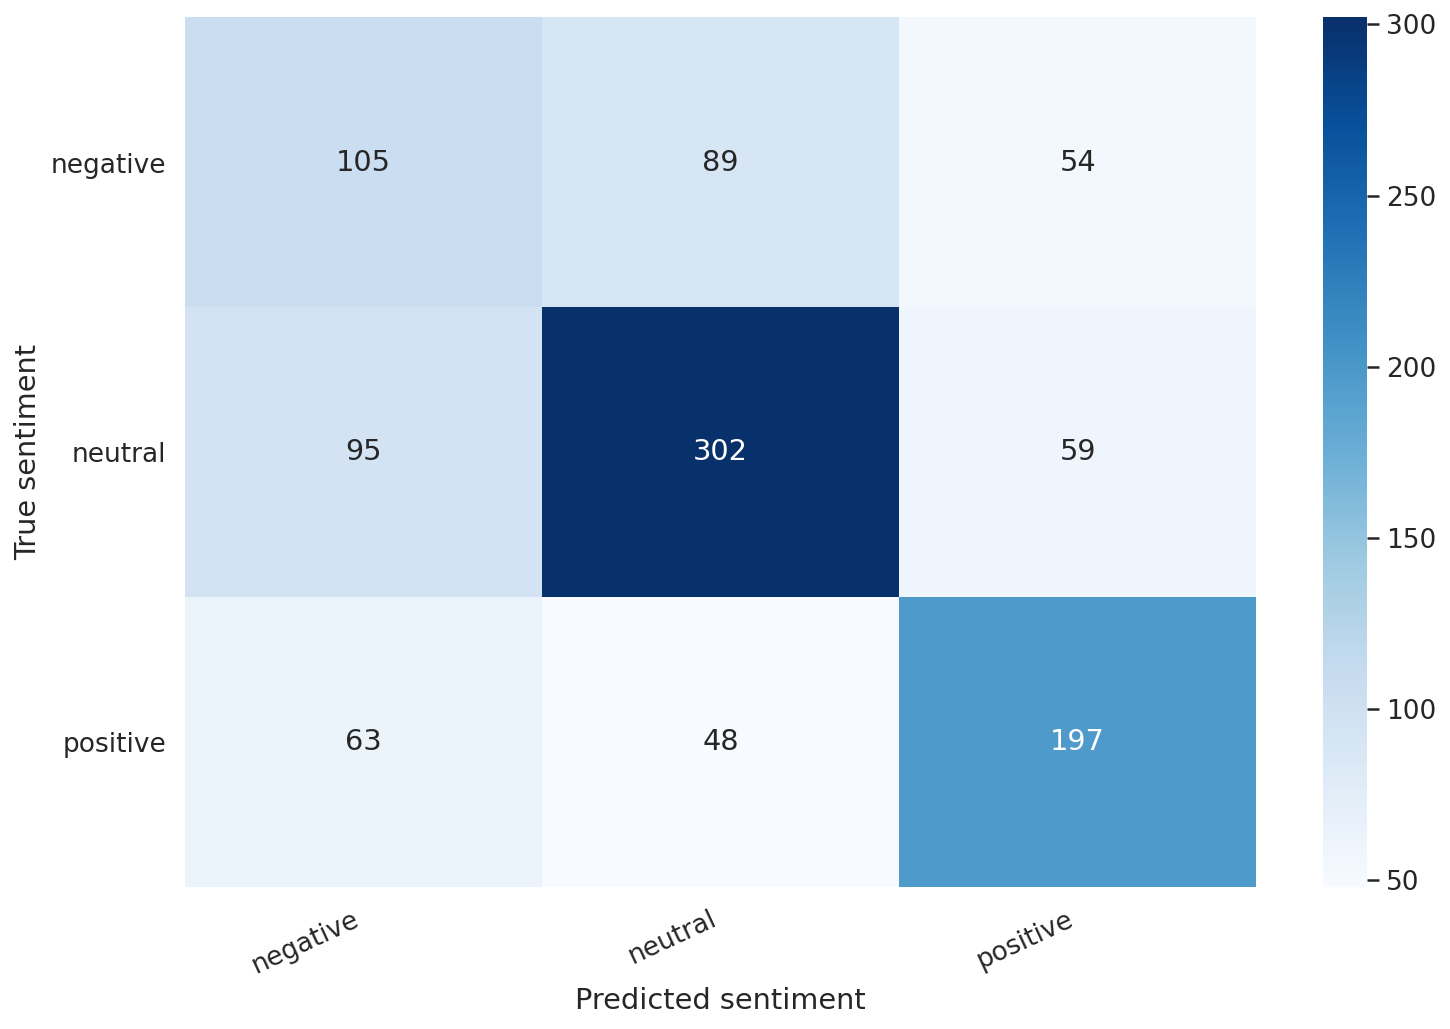

In [86]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=25, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm) 

let's have a look at an example from our test data.

In [82]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
}) 

In [83]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}') 

datacell opn nh horha

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model.

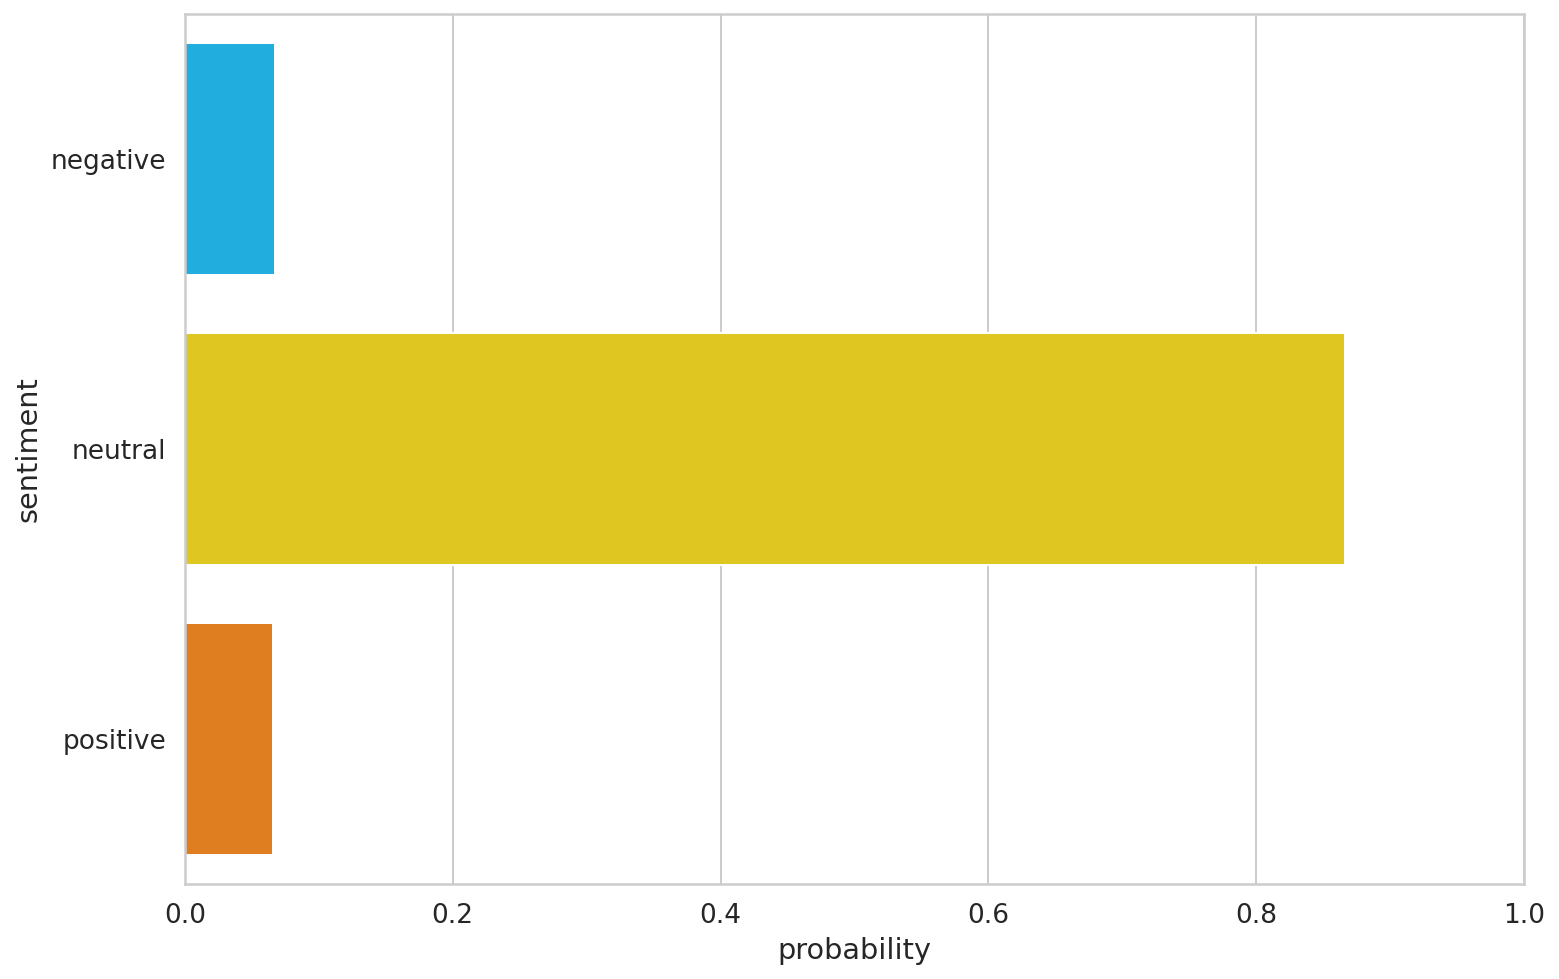

In [84]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]); 

###**Predicting on Raw Text**

Let's use our model to predict the sentiment of some raw text.

In [72]:
test_text = "Kya Hal Hai?" 

We have to use the tokenizer to encode the text.

In [74]:
encoded_review = tokenizer.encode_plus(
  test_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Let's get the predictions from our model.

In [75]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')  

Review text: Kya Hal Hai?
Sentiment  : neutral
